In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from functools import reduce

%matplotlib inline

Prepare the data (get the time series for the following cryptocurrencies from cryptowat.ch starting from 2021-11-22, hourly data):

In [2]:
def get_data(token, exchange):
    res = requests.get(
        f'https://api.cryptowat.ch/markets/{exchange}/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
        }
    )

    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    df.set_index('ts')
    return df
tokens = ['ETH', 'SOL', 'AVAX', 'USDT', 'FLOW']
exchanges = ['coinbase-pro'] * 4 + ['kraken']
dfs = [get_data(token, exchange) for token, exchange in zip(tokens, exchanges)]

Get the total USD volume traded for each token in a dataframe, sorted from highest volume to lowest volume: 

In [3]:
volume_rank = pd.Series(
    [df.volumeUSD.sum() for df in dfs],
    index = tokens,
    name = 'volume rank in USD'
         )
volume_rank.sort_values(inplace = True, ascending = False)
volume_rank

ETH     2.496587e+10
SOL     8.170711e+09
AVAX    4.421678e+09
USDT    2.262217e+09
FLOW    9.679948e+07
Name: volume rank in USD, dtype: float64

Add a column that calculates the close price ratio between ETH and SOL for each house (i.e. close price of ETH / close price of SOL for each period):

In [4]:
for df in dfs:
    df['ratio_ETH_SOL'] = dfs[0].close / dfs[1].close

Change the name of the volume and volumeUSD columns to volumeBase and volumeTerm:

In [5]:
for df in dfs:
    df.rename(
        columns = {
            'volume':'volumeBase',
            'volumeUSD':'volumeTerm'}, 
        inplace = True)

Create a fat table indexed by the timestamp, and each column is the close price of each token (i.e. this should be a table of 200 rows and 5 columns):

In [6]:
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')
fat_table = reduce(
    df_merge, 
    [df[['ts', 'close']].rename(columns={'close': f'close_{token}'}) for df, token in zip(dfs, tokens)])
fat_table.set_index('ts', inplace = True)
fat_table

,close_ETH,close_SOL,close_AVAX,close_USDT,close_FLOW
ts,,,,,
2021-11-22 00:00:00,4262.99,230.785,128.67,1.0012,14.150
2021-11-22 01:00:00,4234.37,226.000,134.85,1.0013,13.621
2021-11-22 02:00:00,4217.89,227.037,132.54,1.0012,13.753
2021-11-22 03:00:00,4193.47,223.117,133.38,1.0011,13.652
2021-11-22 04:00:00,4168.35,220.652,136.29,1.0009,13.581
...,...,...,...,...,...
2021-12-19 11:00:00,3925.13,184.480,110.87,1.0004,8.483
2021-12-19 12:00:00,3927.63,185.000,111.50,1.0003,8.486
2021-12-19 13:00:00,3943.22,185.270,111.59,1.0003,8.531


Calculate the hour by hour log return of the close price of each token (return is calculated by np.log(price_t / price_{t-1})):

In [7]:
returns = np.log(fat_table.drop(fat_table.head(1).index).to_numpy() 
             / fat_table.drop(fat_table.tail(1).index).to_numpy())
fat_table2 = pd.DataFrame(returns, 
                          index = list(fat_table.drop(fat_table.head(1).index).index), 
                          columns = [f'return_{token}' for token in tokens])
fat_table2

,return_ETH,return_SOL,return_AVAX,return_USDT,return_FLOW
2021-11-22 01:00:00,-0.006736,-0.020952,0.046912,0.0001,-0.038102
2021-11-22 02:00:00,-0.003900,0.004578,-0.017279,-0.0001,0.009644
2021-11-22 03:00:00,-0.005806,-0.017417,0.006318,-0.0001,-0.007371
2021-11-22 04:00:00,-0.006008,-0.011109,0.021583,-0.0002,-0.005214
2021-11-22 05:00:00,-0.002472,-0.015161,-0.031832,-0.0001,-0.014014
...,...,...,...,...,...
2021-12-19 11:00:00,-0.004662,-0.002869,-0.008353,0.0000,-0.002120
2021-12-19 12:00:00,0.000637,0.002815,0.005666,-0.0001,0.000354
2021-12-19 13:00:00,0.003961,0.001458,0.000807,0.0000,0.005289
2021-12-19 14:00:00,0.005586,0.006242,0.003935,0.0000,0.003394


(Stretch) calculate the correlation of the tokens using the table above:

In [8]:
corM = fat_table2.corr()
corM

,return_ETH,return_SOL,return_AVAX,return_USDT,return_FLOW
return_ETH,1.000000,0.757332,0.654702,-0.091520,0.583202
return_SOL,0.757332,1.000000,0.646390,0.105489,0.476854
return_AVAX,0.654702,0.646390,1.000000,0.010976,0.404331
return_USDT,-0.091520,0.105489,0.010976,1.000000,-0.176573
return_FLOW,0.583202,0.476854,0.404331,-0.176573,1.000000


(Stretch) visualize the correlation in a matplpotlib plot:

[Text(0, 0, 'ETH'),
 Text(0, 1, 'SOL'),
 Text(0, 2, 'AVAX'),
 Text(0, 3, 'USDT'),
 Text(0, 4, 'FLOW')]

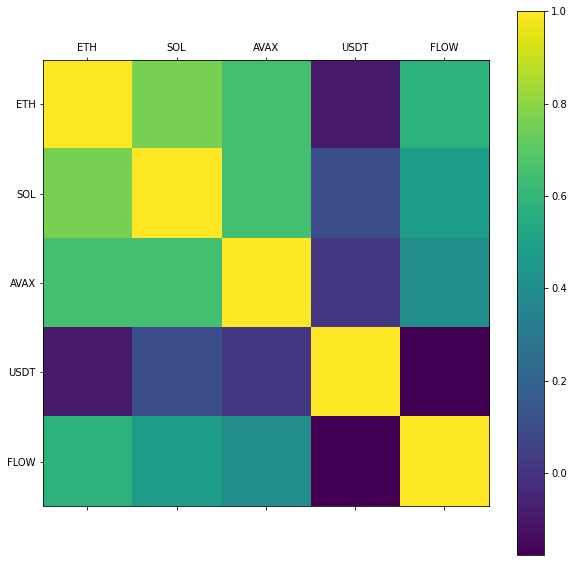

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
fig.colorbar(axes.matshow(corM))
ticks = np.arange(0,5,1)
axes.set_xticks(ticks)
axes.set_yticks(ticks)
axes.set_xticklabels(tokens)
axes.set_yticklabels(tokens)